In [1]:
%matplotlib inline


Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)`` that
returns the ``output``.


A simple feed-forward network takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

Define the network
------------------

Let’s define our denoising network:



In [2]:
import torch
import torch.nn as nn


class DenoiseCnn(nn.Module):
    def __init__(self, num_chans=64, num_layers=4):
        super(DenoiseCnn, self).__init__()
        # store the inputs as class attributes
        self.num_chans = num_chans
        self.num_layers = num_layers
        
        # create the layers
        layer_list = []
        in_ch = 1
        out_ch = num_chans
        
        for i in range(num_layers):
            if i > 0:
                in_ch = num_chans  # first layer
            if i == num_layers - 1:
                out_ch = 1  # last layer

            layer_list.append(
                 nn.Conv2d(
                    in_channels=in_ch,  # num input channels
                    out_channels=out_ch,  # number of filters
                    kernel_size=5,  # size of the filter
                    padding=2  # padding for border of image
                )
            )
            layer_list.append(
                 # applies a covariate shift for faster training 
                nn.BatchNorm2d(out_ch)
            )
            layer_list.append(
                nn.ReLU()  # non-linear activation function: Rectified linear unit 
            )

        print('layer_list before putting into sequential')
        print(layer_list)
        # combine it all into a PyTorch sequential module
        self.conv_sequence = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.conv_sequence(x)

net = DenoiseCnn()
print('')
print('after sequential')
print(net)

layer_list before putting into sequential
[Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(), Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(), Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(), Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU()]

after sequential
DenoiseCnn(
  (conv_sequence): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(

**NOTE** ``torch.nn`` supports inputs that are a minibatch of samples. For examples ``nn.Conv2d`` will take in a 4D Tensor of
``nSamples x nChannels x Height x Width``.

Training a neural network
=========================
To train the denoising network we will do the following steps

1. Load and transform the knee images 
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

**Data loading**

You can use standard python packages that load image data into a numpy array. Then you can convert this array into a torch Tensor.

- For images, packages such as Pillow, OpenCV are useful


In [3]:
import data.transforms as transforms
from data.kneedata import KneeDataSet

*Set up a list of transformations for the data*

In [4]:
noise_sigma = 4e-5
transform_list = [
    transforms.AddNoise(target_op=False, sigma=noise_sigma),
    transforms.Ifft(norm='ortho'),
    transforms.SquareRootSumSquare(),
    transforms.Normalize(),
    transforms.ToTensor(dat_complex=False, target_complex=False)
]

*Define the datasets*

In [5]:
train_dataset = KneeDataSet(
    'pytorch_tutorial_data/',
    'train',
    transform=transforms.Compose(transform_list)
)

print(train_dataset)

val_dataset = KneeDataSet(
    'pytorch_tutorial_data/',
    'val',
    transform=transforms.Compose(transform_list)
)

print(val_dataset)


KneeDataSet
------------------------------------------------------------
directory: pytorch_tutorial_data/train
total number of slices: 324

Transform List:
AddNoise
Ifft
SquareRootSumSquare
Normalize
ToTensor


KneeDataSet
------------------------------------------------------------
directory: pytorch_tutorial_data/val
total number of slices: 109

Transform List:
AddNoise
Ifft
SquareRootSumSquare
Normalize
ToTensor



In [6]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
)

**Display an example training pair**

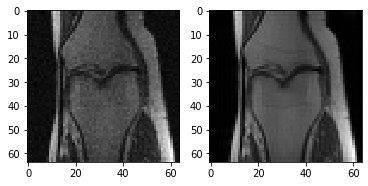

In [7]:
from log_functions import plot_pair, print_stats

dataiter = iter(train_loader)
sample = dataiter.next()

dat, target = sample['dat'], sample['target']

plot_pair(dat, target)


**Now that all the data loading and processing has been taken care of, we can define our model **

In [8]:
model = DenoiseCnn(
    num_chans=64,
    num_layers=4,
)

print(model)

layer_list before putting into sequential
[Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(), Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(), Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(), Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU()]
DenoiseCnn(
  (conv_sequence): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, mom

**We also need to specify the optimizer and loss function**

In [9]:
optimizer = torch.optim.Adam(model.parameters()) # default learning rate
loss_fn = torch.nn.MSELoss()

**Now we finally train the model**

In [10]:
import numpy as np
import time

start_time = time.perf_counter()

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = []
    for batch in train_loader:
        target = batch['target']
        dat = batch['dat']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(dat)
        loss = loss_fn(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    
    current_time = time.perf_counter()
    print('epoch {} finished, elapsed time: {:.0f} seconds, average loss: {:.4f}'.format(
        epoch, current_time-start_time, np.mean(running_loss)))
    
end_time = time.perf_counter()

print('finished training, elapsed time: {:.0f} seconds'.format(
    end_time-start_time))

epoch 0 finished, elapsed time: 50 seconds, average loss: 0.0658
epoch 1 finished, elapsed time: 102 seconds, average loss: 0.0186
epoch 2 finished, elapsed time: 154 seconds, average loss: 0.0107
epoch 3 finished, elapsed time: 203 seconds, average loss: 0.0084
epoch 4 finished, elapsed time: 256 seconds, average loss: 0.0079
epoch 5 finished, elapsed time: 305 seconds, average loss: 0.0065
epoch 6 finished, elapsed time: 356 seconds, average loss: 0.0057
epoch 7 finished, elapsed time: 407 seconds, average loss: 0.0054
epoch 8 finished, elapsed time: 456 seconds, average loss: 0.0053
epoch 9 finished, elapsed time: 508 seconds, average loss: 0.0057
epoch 10 finished, elapsed time: 557 seconds, average loss: 0.0050
epoch 11 finished, elapsed time: 605 seconds, average loss: 0.0045
epoch 12 finished, elapsed time: 654 seconds, average loss: 0.0043
epoch 13 finished, elapsed time: 703 seconds, average loss: 0.0044
epoch 14 finished, elapsed time: 752 seconds, average loss: 0.0039
epoch 

**Now we want to evaluate the trained model on unseen data**


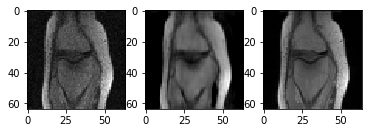

In [12]:
from log_functions import plot_trio

sample = val_dataset[15]
dat, target = sample['dat'].unsqueeze(0), sample['target'].unsqueeze(0)

model = model.eval()
with torch.no_grad():
    outputs = model(dat) # inference step

plot_trio(dat, outputs.numpy(), target)